In [49]:
from spot_clean import clean
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import pickle
import numpy as np

In [50]:
df = pd.read_excel("Spotify.xlsx")
df = clean(df)
df_full = df.copy()
df.drop(["title","artist","add_month","add_year" , "pop","year","genre"],axis = 1 , inplace = True)
df

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch
22,108,47,73,-8,17,25,292,56,3
24,97,49,70,-10,15,63,258,30,3
28,108,61,84,-6,11,78,244,33,3
34,99,17,48,-18,13,20,320,91,4
38,103,53,56,-10,5,45,223,0,3
...,...,...,...,...,...,...,...,...,...
2073,112,60,82,-7,10,93,221,82,3
2075,75,38,46,-10,28,33,234,61,3
2076,152,68,76,-7,14,43,194,53,16
2077,118,59,85,-4,18,68,189,81,5


## Feature Enginering

In [51]:
df_clus = df.copy()
scaler = StandardScaler()

df_clus[list(df.columns)] = scaler.fit_transform(df_clus)

In [52]:
df_clus

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch
22,-0.602906,-0.669834,1.014435,-0.288147,0.132909,-1.096419,1.273628,0.688228,-0.391807
24,-0.957477,-0.547819,0.759263,-1.067411,-0.075519,0.741293,0.290355,-0.296263,-0.391807
28,-0.602906,0.184271,1.950063,0.491118,-0.492374,1.466706,-0.114522,-0.182668,-0.391807
34,-0.893010,-2.500060,-1.111993,-4.184468,-0.283946,-1.338223,2.083383,2.013505,-0.136693
38,-0.764075,-0.303789,-0.431536,-1.067411,-1.117656,-0.129202,-0.721838,-1.432215,-0.391807
...,...,...,...,...,...,...,...,...,...
2073,-0.473971,0.123264,1.779949,0.101486,-0.596587,2.192118,-0.779678,1.672719,-0.391807
2075,-1.666620,-1.218902,-1.282107,-1.067411,1.279260,-0.709532,-0.403720,0.877553,-0.391807
2076,0.815379,0.611324,1.269606,0.101486,-0.179732,-0.225924,-1.560513,0.574633,2.924671
2077,-0.280569,0.062256,2.035120,1.270382,0.237123,0.983097,-1.705112,1.634854,0.118420


Reduce dimension of the data by applying PCA

In [53]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(df_clus) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head()

,P1,P2
0,1.414517,-0.058678
1,0.591573,1.059781
2,-0.943153,1.827426
3,5.309372,-0.398625
4,0.351216,0.237613


# Compare the distortion score from the elbow method


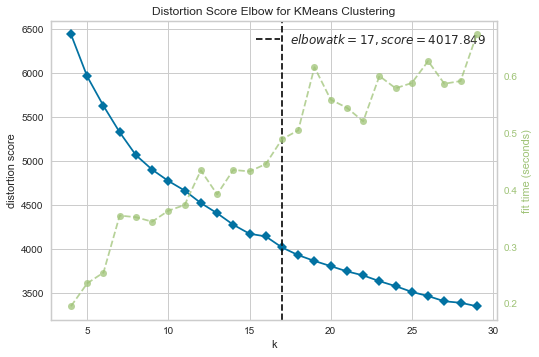

In [54]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,30))
visualizer.fit(df_clus)       
visualizer.show()

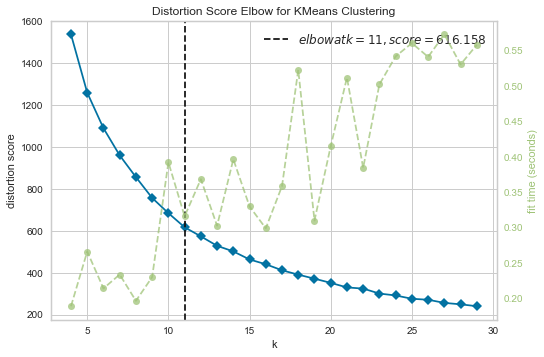

In [55]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,30))
visualizer.fit(X_principal)        
visualizer.show()

We use two types of data to see the distortion score . We will see that the data from PCA have lowest distortion score followed by original data. 

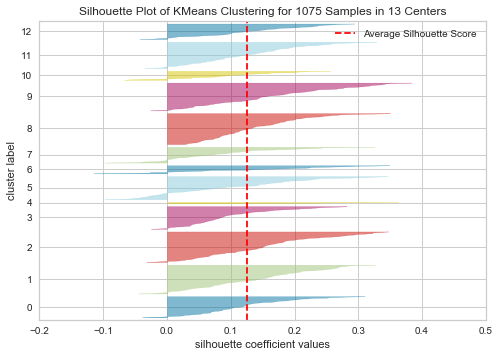

In [56]:
model = KMeans(13, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_clus)       
visualizer.show()

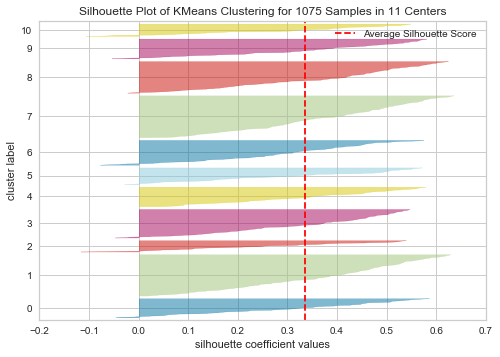

In [57]:
model = KMeans(11, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_principal)       
visualizer.show()

In contrast, we will see that the average silhouette score from PCA is much higher compare to the original data so we decide to use the data from PCA.

In [58]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(X_principal)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [59]:
X_principal["clus"] = kmeans.labels_
X_principal["clus"] = X_principal["clus"].astype('category')

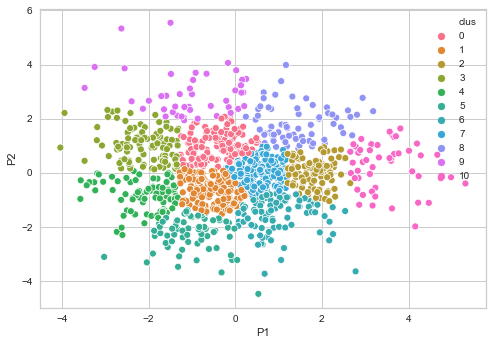

In [60]:
sns.scatterplot(data=X_principal, x= "P1", y= "P2", hue="clus")

In [61]:
df["clus"] = kmeans.labels_
df_full["clus"] = kmeans.labels_


df["clus"] = df["clus"].astype("category")

In [62]:
df_corr = df.copy()
df_corr = pd.get_dummies(df_corr,prefix=["encode"],columns=["clus"])
df.head()

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,clus
22,108,47,73,-8,17,25,292,56,3,2
24,97,49,70,-10,15,63,258,30,3,0
28,108,61,84,-6,11,78,244,33,3,0
34,99,17,48,-18,13,20,320,91,4,10
38,103,53,56,-10,5,45,223,0,3,7


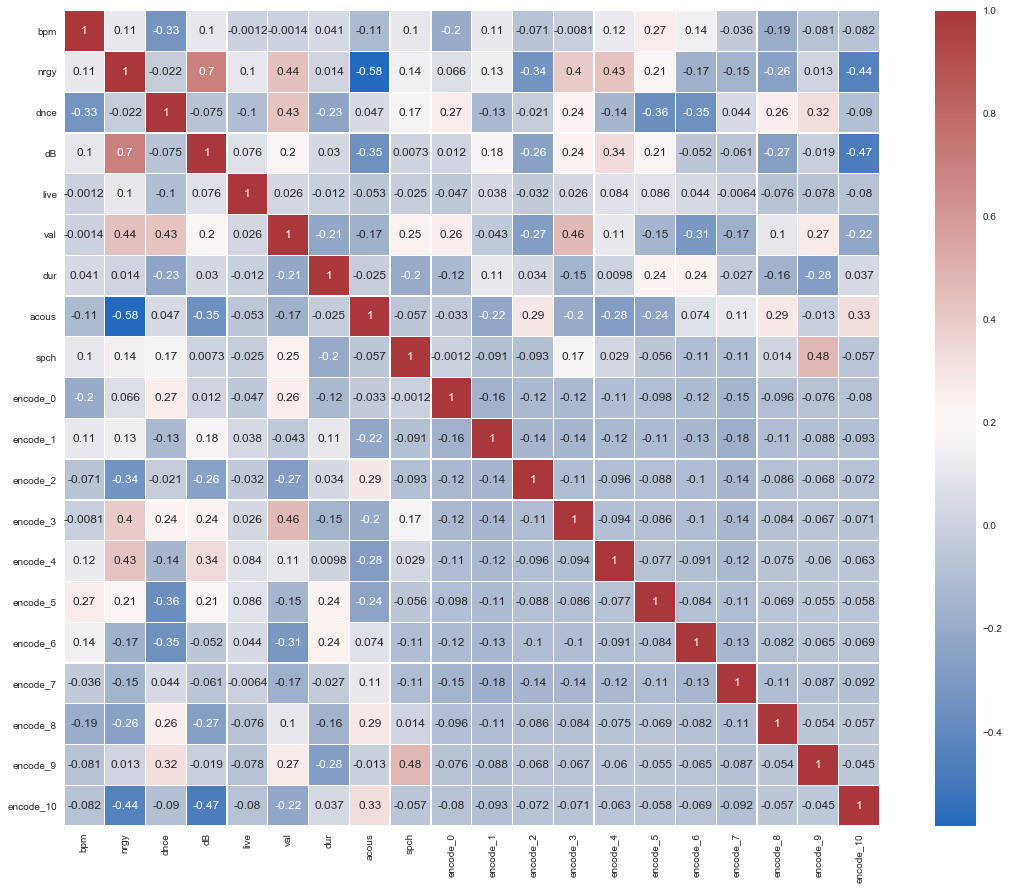

In [63]:
corr = df_corr.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr, cmap="vlag",square = True , annot = True,linewidths = 0.3)
plt.show()

In [64]:
df_full["genre"] = df_full["genre"].replace({"classic thai pop" : "thai classic pop" , "Unknown" : "thai Unknown"} )
df_full["genre"] = df_full["genre"].str[5:]
df_chart = df_full[["genre","clus"]]

alt.Chart(df_chart).mark_bar().encode(
    x='genre:N',
    y='count(genre):Q',
    color='genre:N',
    column='clus:N'
)

alt.Chart(...)

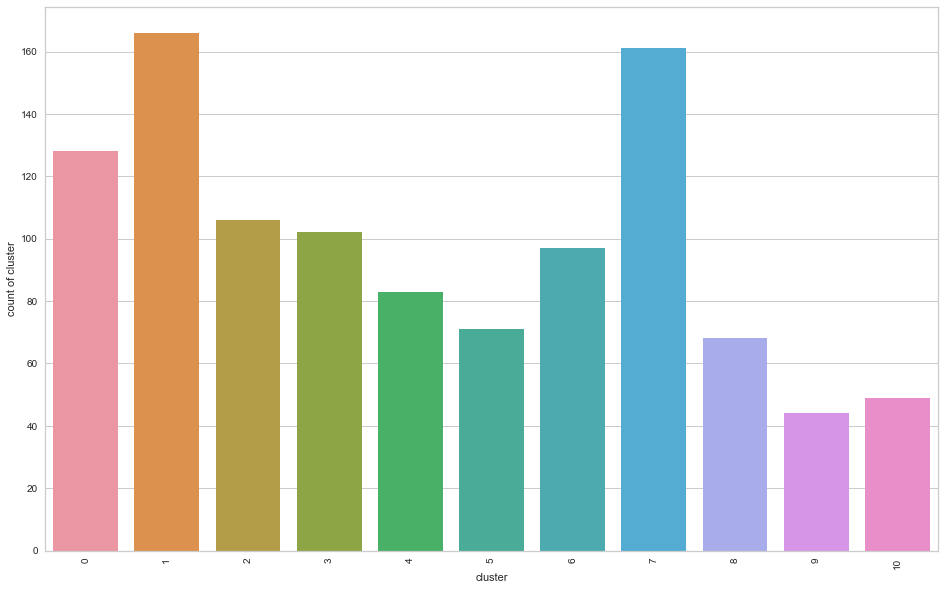

In [65]:
plt.figure(figsize=(16, 10))
ax = sns.barplot(x = df.clus.value_counts().index , y = df.clus.value_counts())
plt.xticks(rotation = 90)
ax.set(xlabel='cluster', ylabel='count of cluster')
plt.show()

## Save the model and the data for the model production

In [86]:
pickle.dump(kmeans , open('km.pkl' , 'wb') )

In [66]:
pickle.dump(scaler , open('scaler.pkl' , 'wb') )

In [87]:
pickle.dump(pca, open('pca.pkl' , 'wb') )

In [88]:
df_full.to_csv('df_clus', index=False)